In [1]:
import numpy as np 
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spamcsv/spam.csv


In [2]:
# import the necessary libraries
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential 
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')


In [4]:
df = pd.read_csv("/kaggle/input/spamcsv/spam.csv", encoding='UTF-8')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
print("DataFrame Size:", df.shape)

DataFrame Size: (5572, 2)


# Distribution of categories.

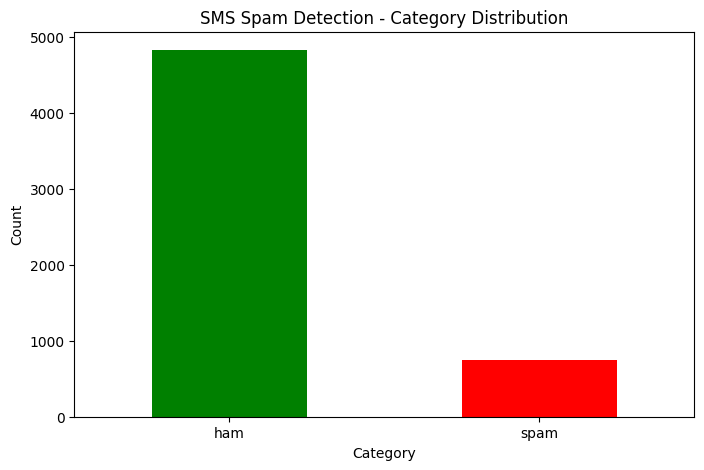

Category
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
# Count the occurrences of each category
category_counts = df['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['green', 'red'])
plt.title('SMS Spam Detection - Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

df['Category'].value_counts()

# Distribution of words in the sms

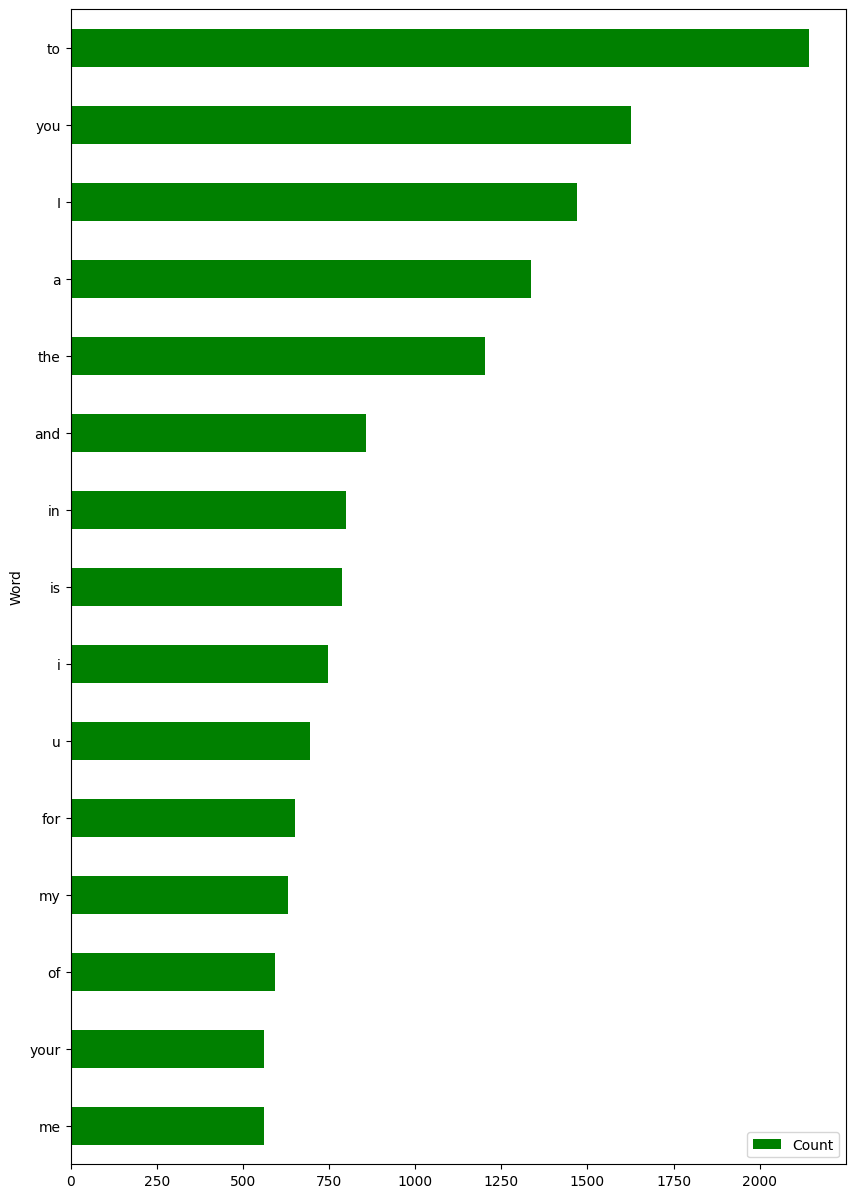

In [7]:
def word_count_plot(data):
     
     word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
     most_count = word_counter.most_common(15)
     
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
    
word_count_plot(df['Message'])

# Preprocessing the data by tokenizing and padding the textual data and encoding the categorical classification labels

In [8]:
maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Message'])

# Convert the text data to sequences of integers
sequences = tokenizer.texts_to_sequences(df['Message'])

# Get the word index (Dictionary mapping words to their integer indices)
word_index = tokenizer.word_index
print('Found ', len(word_index), ' unique tokens.')

label_encoder = preprocessing.LabelEncoder()
classification = label_encoder.fit_transform(df['Category'])

# Pad sequences to ensure uniform length
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(classification)
print('Shape of the tensor containing the SMSes:', data.shape)
print('Shape of the tensor containing the classifcation labels:', labels.shape)


Found  9004  unique tokens.
Shape of the tensor containing the SMSes: (5572, 100)
Shape of the tensor containing the classifcation labels: (5572,)


# Splitting the data into train, validation and test sets

In [9]:
training_samples = 3000
validation_samples = 2000
testing_samples = 572

from sklearn.model_selection import train_test_split

# Assuming data and labels are already defined
# Replace 'labels' with your actual label array

# Shuffle and split the data
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=(validation_samples + testing_samples), random_state=42)

# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=testing_samples, random_state=42)

# Print the sizes of the sets
print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))


Training set size: 3000
Validation set size: 2000
Test set size: 572


# LSTM model

In [10]:
VOC_SIZE = len(tokenizer.word_index)+1
model = Sequential()
model.add(Embedding(VOC_SIZE, 32, input_length=maxlen))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           288160    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 343401 (1.31 MB)
Trainable params: 343401 

In [11]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])
lstm = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
94/94 [==============================] - 16s 115ms/step - loss: 0.3506 - acc: 0.8887 - val_loss: 0.1083 - val_acc: 0.9735
Epoch 2/10
94/94 [==============================] - 6s 63ms/step - loss: 0.1139 - acc: 0.9767 - val_loss: 0.0600 - val_acc: 0.9845
Epoch 3/10
94/94 [==============================] - 4s 38ms/step - loss: 0.0595 - acc: 0.9880 - val_loss: 0.0605 - val_acc: 0.9870
Epoch 4/10
94/94 [==============================] - 3s 32ms/step - loss: 0.0434 - acc: 0.9900 - val_loss: 0.0776 - val_acc: 0.9725
Epoch 5/10
94/94 [==============================] - 3s 31ms/step - loss: 0.0299 - acc: 0.9940 - val_loss: 0.0790 - val_acc: 0.9870
Epoch 6/10
94/94 [==============================] - 2s 17ms/step - loss: 0.0197 - acc: 0.9963 - val_loss: 0.0742 - val_acc: 0.9845
Epoch 7/10
94/94 [==============================] - 2s 17ms/step - loss: 0.0201 - acc: 0.9960 - val_loss: 0.0892 - val_acc: 0.9710
Epoch 8/10
94/94 [==============================] - 2s 20ms/step - loss: 0.0116 -

In [13]:
# Function to create the LSTM model
def create_lstm_model(units=100, dropout_rate=0.4, dense_units=20, dense_dropout_rate=0.5, lstm_activation='tanh', dense_activation='relu'):
    model = Sequential()
    model.add(Embedding(VOC_SIZE, 32, input_length=maxlen))
    model.add(LSTM(units, activation=lstm_activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=dense_activation))
    model.add(Dropout(dense_dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

# hyperparameters
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.3, 0.45],
    'dense_units': [10, 20],
    'dense_dropout_rate': [0.5, 0.6],
    'lstm_activation': ['tanh', 'relu'],
    'dense_activation': ['relu', 'sigmoid']
}

# Placeholder for the best model and accuracy
best_model = None
best_accuracy = 0

# Iterate through hyperparameter combinations
for unit in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for dense_unit in param_grid['dense_units']:
            for dense_dropout_rate in param_grid['dense_dropout_rate']:
                for lstm_activation in param_grid['lstm_activation']:
                    for dense_activation in param_grid['dense_activation']:
                        # Create and compile the model
                        model = create_lstm_model(
                            units=unit,
                            dropout_rate=dropout_rate,
                            dense_units=dense_unit,
                            dense_dropout_rate=dense_dropout_rate,
                            lstm_activation=lstm_activation,
                            dense_activation=dense_activation
                        )

                        # Train the model
                        history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=0)
                        # Get the validation accuracy
                        val_accuracy = history.history['val_acc'][-1]

                        print(f'Validation Accuracy: {val_accuracy:.4f}, Params: {model.get_config()}')
                        # Update the best model if the current one is better
                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_model = model

print("Best Accuracy:", best_accuracy)
print(f'Validation Accuracy: {val_accuracy:.4f}, Params: {best_model.get_config()}')

Validation Accuracy: 0.9835, Params: {'name': 'sequential_2', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 100), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'embedding_2_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_2', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 100), 'input_dim': 9005, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 100}, 'registered_name': None, 'build_config': {'input_shape': (None, 100)}}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': 'float32', 'return_sequences': 

In [14]:
print("Best Accuracy:", best_accuracy)
print(f'Validation Accuracy: {val_accuracy:.4f}, Params: {best_model.get_config()}')

Best Accuracy: 0.9894999861717224
Validation Accuracy: 0.8750, Params: {'name': 'sequential_28', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 100), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'embedding_28_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_28', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 100), 'input_dim': 9005, 'output_dim': 32, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 100}, 'registered_name': None, 'build_config': {'input_shape': (None, 100)}}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_28', 'trainable': True, 'd

# Evaluating the performance of the model

In [15]:
values_2 = best_model.evaluate(x_test,y_test)

18/18 [==============================] - 0s 14ms/step - loss: 0.0341 - acc: 0.9948


In [17]:
lstm = best_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=0)

In [18]:
df = pd.DataFrame()
df['Training Accuracy'] = lstm.history['acc']
df['Validation Accuracy'] = lstm.history['val_acc']
df['Training Loss'] = lstm.history['loss']
df['Validation Loss'] = lstm.history['val_loss']
df['Epochs'] = range(1, len(df['Training Accuracy']) + 1)

# comparing the training and validation accuracy 
fig = px.line(df, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'], title='Training and Validation Accuracy for the LSTM model')
fig.show()

In [19]:
# comparing the training and validation loss
fig = px.line(df, x='Epochs', y=['Training Loss', 'Validation Loss'], title='Training and Validation Loss for the LSTM model')
fig.show()